In [1]:
import os
import sys

os.chdir(os.path.dirname(sys.path[0]))

# Wind power curve modelling
Wind power curves show the non-linear relationship between wind speed and wind power, are required for effective integration of wind power into the power system, as well as wind turbine condition monitoring projects.

### Typical power curve
<img src="/home/francisco/GitRepos/predictive_maintenance/assets/images/typical-wind-power-curve.png" alt="A typical power curve" width="600"/>

The power curve of a wind turbine presents the electrical power output ratings of the machine for different wind speeds.
A typical wind turbine power curve has three main characteristic speeds: 
* 1) cut-in
* 2) rated
* 3) cut-out

The turbine starts generating power when the wind speed reaches the cut-in value. The rated speed is the wind speed at which the generator is producing the machine’s rated power. When the wind speed reaches the cut-out speed, the power generation is shut down to prevent defects and damages. Theoretical power curves are supplied by manufacturers assuming ideal meteorological and topographical conditions.

Power curve are model specific are provided by the manufacturer and are theoretical. In practice, however, wind turbines are never used under ideal conditions, and the empirical power curves could be substantially different from the theoretical ones due to the location of the turbine, air density, wind velocity distribution, wind direction, mechanical and control issues, as well as uncertainties in measurements.

The wind power curve characterizes wind turbine generation under normal conditions, so it can be used as an online wind turbine power generation profile. This can help us understand whether a wind turbine works under normal conditions, and then allowing for troubleshooting and scheduling maintenance, as well as repair interventions when the turbine is faulty. Understanding potential failures will help maintain and improve the operational efficiency and reliability of wind energy conversion systems.

### Exploring wind power data
In Wind Turbines, Scada Systems measure and save data's like wind speed, wind direction, generated power etc. for 10 minutes intervals. This file was taken from a wind turbine's scada system that is working and generating power in Turkey.

In [2]:
import pandas as pd

wind_df = pd.read_csv("wind/data/T1.csv")

wind_df.describe()

,LV ActivePower (kW),Wind Speed (m/s),Theoretical_Power_Curve (KWh),Wind Direction (°)
count,50530.000000,50530.000000,50530.000000,50530.000000
mean,1307.684332,7.557952,1492.175463,123.687559
std,1312.459242,4.227166,1368.018238,93.443736
min,-2.471405,0.000000,0.000000,0.000000
25%,50.677890,4.201395,161.328167,49.315437
50%,825.838074,7.104594,1063.776283,73.712978
75%,2482.507568,10.300020,2964.972462,201.696720
max,3618.732910,25.206011,3600.000000,359.997589


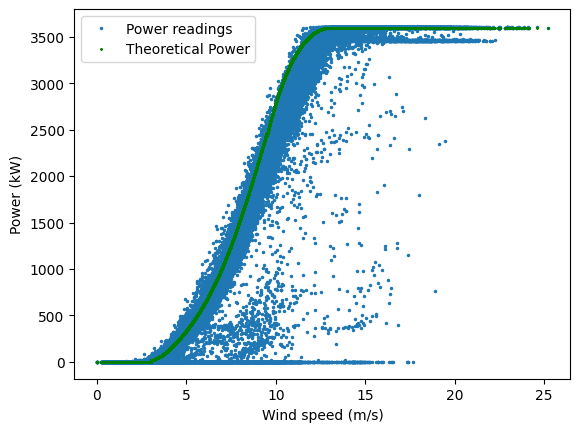

In [3]:
import matplotlib.pyplot as plt

plt.plot(wind_df['Wind Speed (m/s)'], wind_df['LV ActivePower (kW)'], marker='o', linestyle='none', markersize=1.5, label='Power readings')
plt.plot(wind_df['Wind Speed (m/s)'], wind_df['Theoretical_Power_Curve (KWh)'], marker='*', linestyle='none', color='green', markersize=1.5, label='Theoretical Power')
plt.xlabel('Wind speed (m/s)')
plt.ylabel('Power (kW)')
plt.legend()
plt.show()

This dataset contains real world data. The power dispersion (vertical axis) that we can observe at different wind speeds shows plenty of outliers.

We can expect outliers in a normal operational setting:
* Wind curtailment - If there is no energy demand its possible that the operators intentionally reduced the power output.
* Turbine maintenance - The high density of 0 output recordings suggests that there is a considerable amount of downtime in the turbine. This is possibly due to maintenance.

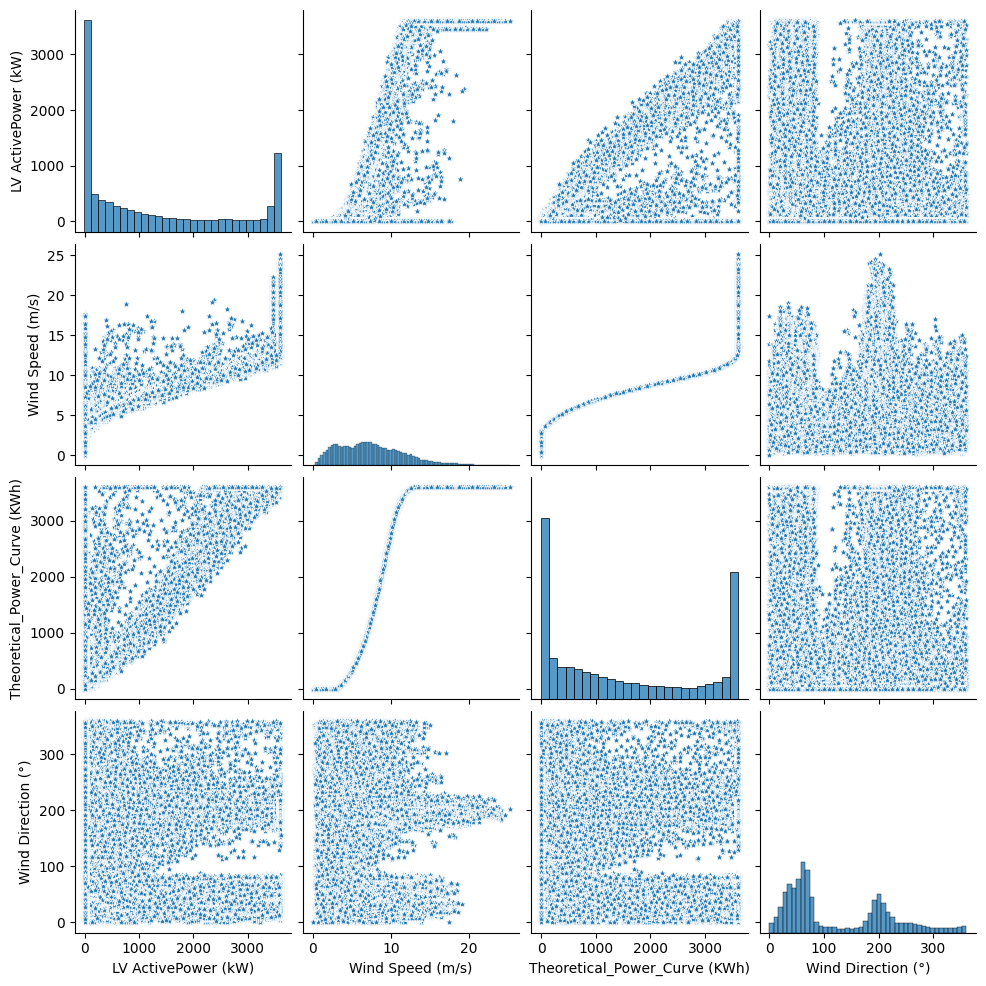

In [4]:
import seaborn as sns

sns.pairplot(wind_df[[col for col in wind_df.columns]], markers='*')

We should try to clean the data of outliers before fitting an empirical power curve to compare with the manufacturer provided power curve.

### Data cleaning
To clean the data we can resort to packages like PyOD. This allows us to fit a model to the data in an unsupervised manner or in a supervised manner (maybe using the theoretical power curve as label?). We will implement an unsupervised Outlier Detection model and assess the cleaned data.

In [5]:
from sklearn.decomposition import PCA
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import FunctionTransformer, StandardScaler

def get_pipe_components(use_scaler:bool=True, use_pca:bool=True):
    pipe = []

    identity = ("passthrough", lambda x: x)  # Make the pipeline logic reusable even if no scale or pca is used
    scaler = ("scaler", StandardScaler())
    pca = ("pca", PCA(n_components=2))

    if use_scaler:
        pipe.append(scaler)
    if use_pca:
        pipe.append(pca)
    if not pipe:
        pipe.append(identity)
    return pipe

# Configure the pipeline
use_scaler = True
use_pca = True

pipeline = Pipeline(get_pipe_components(use_scaler, use_pca))

/home/francisco/miniconda3/envs/pred_maint/lib/python3.10/site-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


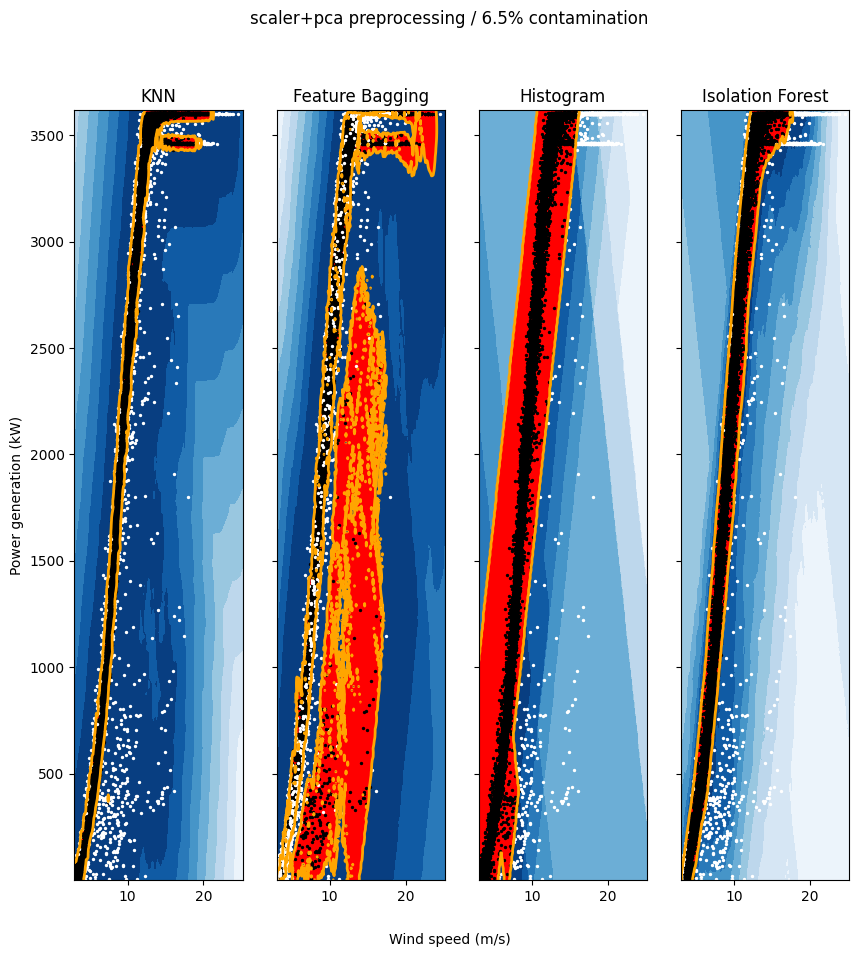

In [6]:
import numpy as np
from pyod.models.feature_bagging import FeatureBagging
from pyod.models.hbos import HBOS
from pyod.models.iforest import IForest
from pyod.models.knn import KNN
from sklearn.model_selection import train_test_split

random_state=42

wind_od_df = wind_df.loc[
    ((wind_df['Theoretical_Power_Curve (KWh)']>0) & (wind_df['LV ActivePower (kW)']>0)),  # Only when the turbine is above cut-in and generating power
    ['Wind Speed (m/s)', 'LV ActivePower (kW)']  # Discard time, wind direction and theoretical curve (unsupervised OD)
    ]

mesh_points = 200
mesh_x , mesh_y = np.meshgrid(
    np.linspace(wind_od_df['Wind Speed (m/s)'].min(), wind_od_df['Wind Speed (m/s)'].max(), mesh_points),
    np.linspace(wind_od_df['LV ActivePower (kW)'].min(), wind_od_df['LV ActivePower (kW)'].max(), mesh_points)
    )

wind_od_df[wind_od_df.columns] = pipeline.fit_transform(wind_od_df)

scaled_mesh = pipeline.transform(np.c_[mesh_x.ravel(), mesh_y.ravel()])

x_train, x_test = train_test_split(wind_od_df, test_size=1/3, random_state=random_state)
_x_test = pd.DataFrame.copy(x_test, deep=True)
_x_test[_x_test.columns] = pipeline.inverse_transform(x_test)

contamination = .065

od_models = {
    "KNN": KNN(n_neighbors=10, contamination=contamination),
    "Feature Bagging": FeatureBagging(contamination=contamination, random_state=random_state),
    "Histogram": HBOS(n_bins=10, tol=.5, contamination=contamination),
    "Isolation Forest": IForest(n_estimators=200, max_samples=.10, contamination=contamination, random_state=random_state)
}

fig, subplots = plt.subplots(1, len(od_models), sharey=True)

for i, (model_name, model) in enumerate(od_models.items()):
    model.fit(x_train)

    prediction = model.predict(x_test.values)
    scores = model.decision_function(x_test.values)
    
    mesh_scores = model.decision_function(scaled_mesh)
    mesh_scores = mesh_scores.reshape(mesh_x.shape)

    subplot = subplots[i]
    if i==0:
        subplot.set_ylabel("Power generation (kW)")
        fig.text(0.5, 0.05, "Wind speed (m/s)", ha="center", va="center")
    
    # Plot the results
    subplot.contourf(mesh_x, mesh_y, mesh_scores, levels=[mesh_scores.min(), model.threshold_], colors='red')
    subplot.contourf(mesh_x, mesh_y, mesh_scores, levels=np.linspace(model.threshold_, mesh_scores.max(), 10), cmap=plt.cm.Blues_r)
    dec_function = subplot.contour(mesh_x, mesh_y, mesh_scores, levels=[model.threshold_], linewidths=2, colors='orange')

    inliers = subplot.scatter(
        _x_test.loc[prediction==0, "Wind Speed (m/s)"],
        _x_test.loc[prediction==0, "LV ActivePower (kW)"],
        c="black",
        label='Inliers',
        s=2
        )
    outliers = subplot.scatter(
        _x_test.loc[prediction==1, "Wind Speed (m/s)"],
        _x_test.loc[prediction==1, "LV ActivePower (kW)"],
        c="white",
        label='Outliers',
        s=2
        )
    
    subplot.set_title(model_name)

fig.set_size_inches(10, 10)
fig.suptitle('+'.join([i for i in pipeline.named_steps])+' preprocessing / {:.1%} contamination'.format(contamination))
plt.show()

We will go with the KNN model for outlier detection since it seems to have adapted the decision function the most to a theoretical curve shape.

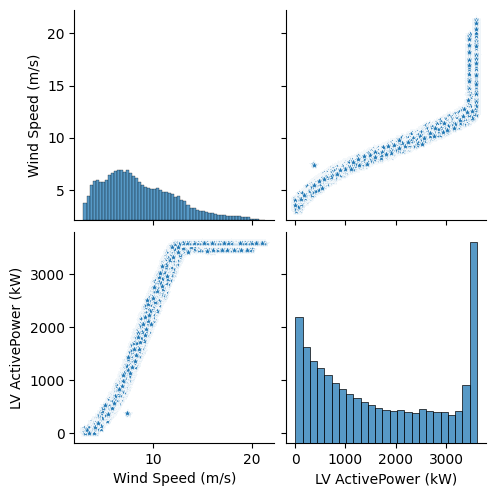

In [7]:
chosen_model = 'KNN'
model = od_models[chosen_model]

wind_od_df['OD_Score'] = model.decision_function(wind_od_df[['Wind Speed (m/s)', 'LV ActivePower (kW)']])
wind_od_df[['Wind Speed (m/s)', 'LV ActivePower (kW)']] = pipeline.inverse_transform(wind_od_df[['Wind Speed (m/s)', 'LV ActivePower (kW)']])
wind_od_df['is_outlier'] = wind_od_df['OD_Score'].apply(lambda x: x>model.threshold_)

wind_model_data = wind_od_df.loc[~wind_od_df.is_outlier]


sns.pairplot(wind_model_data[['Wind Speed (m/s)', 'LV ActivePower (kW)']], markers='*')


### Curve fitting

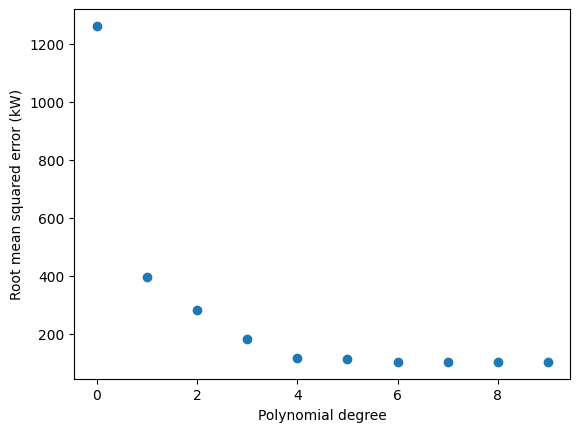

In [8]:
import numpy as np
from sklearn.model_selection import KFold
from sklearn.metrics import mean_squared_error

wind_speed = wind_model_data['Wind Speed (m/s)'].values
power = wind_model_data['LV ActivePower (kW)'].values

pd_values = range(10)  # Polynomial degree values, 0 for constant model, up to 10 degree polynomial

cv_folds = 10
kf_cv = KFold(n_splits=cv_folds, shuffle=True, random_state=42)

mse_values = np.zeros(len(pd_values))
models = [np.zeros((cv_folds, degree+1)) for degree in pd_values]

for i, (train_ixs, test_ixs) in enumerate(kf_cv.split(wind_speed, power)):
    x_train, x_test = wind_speed[train_ixs], wind_speed[test_ixs]
    y_train, y_test = power[train_ixs], power[test_ixs]
    for j, degree in enumerate(pd_values):
        params = np.polyfit(x_train, y_train, degree)
        models[j][i] = params
        model = np.poly1d(params)
        mse_values[j] += mean_squared_error(y_test, model(x_test))

models = [np.poly1d(np.mean(cv_models, axis=0)) for cv_models in models]

rmse_values = np.sqrt(mse_values/cv_folds)

plt.plot([i for i in pd_values], rmse_values, marker='o', linestyle='none')
plt.xlabel('Polynomial degree')
plt.ylabel('Root mean squared error (kW)')
plt.show()

Considering that we have more than 50k datapoints, we are likely far from overfitting on any of the polynomials.

We will select the best model by minimizing the RMSE.

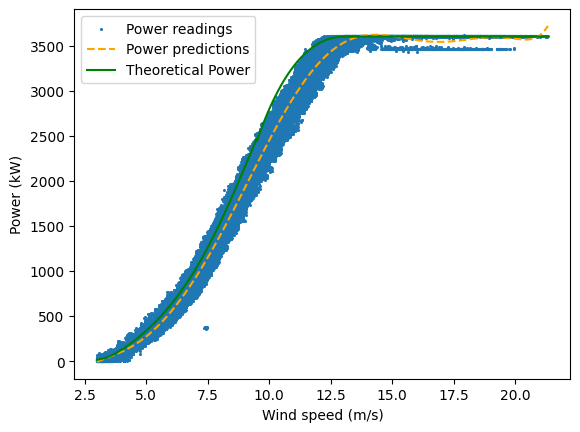

In [9]:
best_model = models[np.argmin(rmse_values)]

predictions = best_model(wind_speed)
theoretical_power = wind_df.loc[wind_model_data.index, 'Theoretical_Power_Curve (KWh)'].values

plt.scatter(wind_speed, power, marker='o', s=1.5, label='Power readings')
plt.plot(sorted(wind_speed), best_model(wind_speed)[np.argsort(wind_speed)], linestyle='--', color='orange', label='Power predictions')
plt.plot(sorted(wind_speed), theoretical_power[np.argsort(wind_speed)], linestyle='-', color='green', label='Theoretical Power')
plt.xlabel('Wind speed (m/s)')
plt.ylabel('Power (kW)')
plt.legend()
plt.show()

Regarding the three characteristic speeds, we can make the following observations:
* The cut-in speed seems to be about 3 m/s
* The rated speed seems to be about 12.5 m/s but for our model this is slightly higher (around 13.5 m/s)
* There is no cut-out speed for this turbine or observations above it were not recorded

As for the model itself we can make the following observations:
* **Flat zones** - the model is unable to represent the flat power readings below cut-in and above the rated speed, this is due to globally fitting the polynomial. To fix this we could make a spline model, a spline for below cut-in, another for between cut-in and rated speed and another above rated speed.
* **Empiric power curve** - It seems that the empiric power curve marks inferior power readings than the theoretical curve. This could be due to a number of reasons:
    * Intentional power output reduction by the operators
    * Ideal wind conditions not verified: air density, wind velocity distribution..
    * Mechanical issues of the equipment or bias in power measurements

## Sources
[1] ["Wind power curve modeling - Kaggle"](https://www.kaggle.com/code/winternguyen/wind-power-curve-modeling)

[2] ["Wind turbine scada dataset - Kaggle"](https://www.kaggle.com/datasets/berkerisen/wind-turbine-scada-dataset?resource=download)